In [2]:
# Some useful imports:
import numpy as np
import tables as tb

# Useful ipython commands:
%matplotlib inline

In [3]:
# Dataset constants:
dataset = 'ad_cn'
input_node = 'l_hc_features'
label_node = 'label'
class_names = ['AD', 'CN']

# Data path constants:
data_path = '/projects/francisco/data/caffe/standardized/combined/'
train_path = data_path + dataset + '_train.h5'
valid_path = data_path + dataset + '_valid.h5'
test_path = data_path + dataset + '_test.h5'

# Load the training set:
data = tb.open_file(train_path, 'r')
X = data.get_node('/' + input_node)[:]
y = data.get_node('/' + label_node)[:]
data.close()

# Load the validation set:
data = tb.open_file(valid_path, 'r')
X_v = data.get_node('/' + input_node)[:]
y_v = data.get_node('/' + label_node)[:]
data.close()


# Load the testing set:
data = tb.open_file(test_path, 'r')
X_t = data.get_node('/' + input_node)[:]
y_t = data.get_node('/' + label_node)[:]
X_t_fused = data.get_node('/' + input_node + '_fused')[:]
y_t_fused = data.get_node('/' + label_node + '_fused')[:]
data.close()

In [4]:
# Import and define the baseline classifiers here:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

# Hyper params (obtained from Spearmint experiments on validation data):
max_depth = 1
n_estimators = 6
learning_rate = 0.90483

stump = DecisionTreeClassifier(max_depth=max_depth)

classifier = AdaBoostClassifier(stump,
                                algorithm="SAMME.R",
                                n_estimators=n_estimators,
                                learning_rate=learning_rate)

In [5]:
# Fit the classifier to training data, then predict test labels.
classifier.fit(X, y)
y_hat = classifier.predict(X)
y_hat_t = classifier.predict(X_t)
y_hat_t_f = classifier.predict(X_t_fused)




In [6]:
# Metrics
from sklearn.metrics import classification_report, accuracy_score

acc = accuracy_score(y_hat, y)
acc_t = accuracy_score(y_hat_t, y_t)
acc_t_f = accuracy_score(y_hat_t_f, y_t_fused)

print 'Metrics on Fused Test Data:'
print classification_report(y_t_fused, y_hat_t_f, target_names=class_names)
print 'Training Accuracy: {}'.format(acc)
print 'Test Accuracy: {}'.format(acc_t)
print 'Fused Test Accuracy: {}'.format(acc_t_f)


Metrics on Fused Test Data:
             precision    recall  f1-score   support

         AD       0.74      0.78      0.76        32
         CN       0.78      0.74      0.76        34

avg / total       0.76      0.76      0.76        66

Training Accuracy: 0.710940860215
Test Accuracy: 0.72053030303
Fused Test Accuracy: 0.757575757576


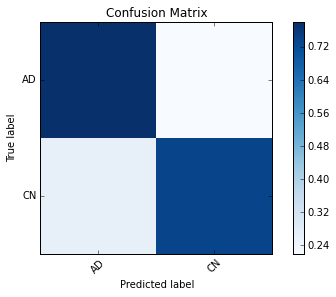

In [8]:
# CM
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

cm = confusion_matrix(y_t_fused, y_hat_t_f)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.imshow(cm_normalized, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')

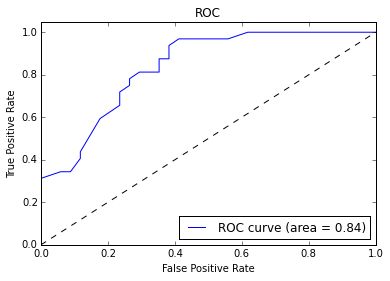

In [9]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

# class probabilities on the fused training data:
y_hat_t_f_scores = classifier.predict_proba(X_t_fused)

# Plot curve for AD class (0)
fpr, tpr, thresholds = roc_curve(y_t_fused, y_hat_t_f_scores[:,0], pos_label=0)
auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

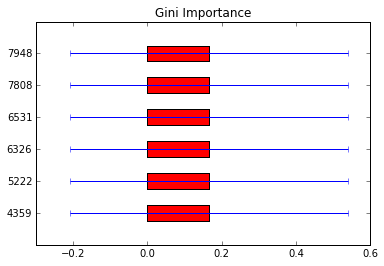

In [11]:
# HC segmentation vars don't have a name:
var_names = range(X.shape[1])

importances = classifier.feature_importances_
importances_std = np.std([tree.feature_importances_ for tree in classifier.estimators_], axis=0)

feats = zip(var_names, importances, importances_std)

# Remove non-important feats:
feats = [feat for feat in feats if feat[1] > 0.0]
feats.sort(reverse=False, key=lambda x: x[1])

# Plot the feature importances of the classifier
plt.figure()
plt.title("Gini Importance")
y_pos = np.arange(len(feats))
plt.barh(y_pos, width=zip(*feats)[1], height=0.5, color='r', xerr=zip(*feats)[2], align="center")
plt.yticks(y_pos, zip(*feats)[0])
plt.show()
